In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# sys.path.append('../src')
# import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### Modelling

In [2]:
from fastai.text.all import *

In [3]:
path = Path('../..')

In [4]:
files = get_text_files(path, folders = ['just_icds'])

In [5]:
len(files)

120789

In [6]:
txts = L(o.open().read().split(' ') for o in files)

In [7]:
len(txts)

120789

In [8]:
lens = [len(t) for t in txts]

In [9]:
np.mean(lens), np.max(lens), np.min(lens)

(411.2740398546225, 14228, 1)

In [10]:
counter = Counter(tok for pat in txts for tok in set(pat))

In [11]:
vocab = make_vocab(counter, min_freq=20)

In [12]:
dls = TextDataLoaders.from_folder(
    path / 'just_icds',
    valid_pct=.1,
    seed=None,
    text_vocab=vocab,
    is_lm=True,
    tok_tfm=None,
    seq_len=72,
    backwards=False,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None
)

In [23]:
learn = language_model_learner(
    dls=dls,
    arch=AWD_LSTM,
    drop_mult=1,
    pretrained=False,
    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4),
    metrics=[accuracy, Perplexity()]).to_fp16()

In [24]:
len(vocab)

10952

In [25]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(10952, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10952, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10952, bias=True)
    (output_dp): RNNDropout()
  )
)

/home/bp/.local/share/virtualenvs/data-analytics-qWXImv-u/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00013182566908653826)

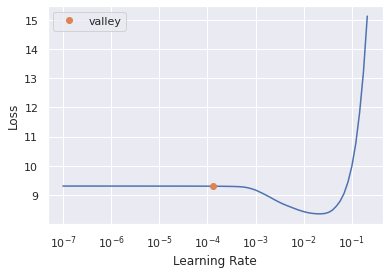

In [22]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(20, 10e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.855841,4.892498,0.194350,133.286102,30:39
1,3.516081,3.396230,0.410725,29.851347,30:16
2,3.042230,2.983474,0.463655,19.756327,30:21
3,2.883500,2.828753,0.483862,16.924339,30:27
4,2.825930,2.738872,0.494305,15.469522,30:15
5,2.805090,2.680237,0.501016,14.588544,30:18
6,2.762902,2.645252,0.505322,14.086994,30:36
7,2.708227,2.614480,0.508642,13.660115,30:18
8,2.745945,2.587319,0.511145,13.294087,30:18
9,2.622487,2.564356,0.513946,12.992293,30:38


### Save model, encoder, and vocab

In [28]:
models_path = '/home/bp/data-analytics/models'
file = models_path + 'lml_epoch_20_20220922.pkl'
file

'/home/bp/data-analytics/modelslml_epoch_20_20220922.pkl'

In [29]:
learn.save(file, with_opt=True, pickle_protocol=2)

Path('/home/bp/data-analytics/modelslml_epoch_20_20220922.pkl.pth')

In [30]:
file = models_path + 'lml_epoch_20_encoder_20220922'
learn.save_encoder(file)

In [31]:
file

'/home/bp/data-analytics/modelslml_epoch_20_encoder_20220922'

In [33]:
vocab_path = models_path + 'lml_epoch_20_vocab_20220922.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
vocab_path

'/home/bp/data-analytics/modelslml_epoch_20_vocab_20220922.pkl'

### Visualize Results

In [34]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(10952, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10952, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10952, bias=True)
    (output_dp): RNNDropout()
  )
)

In [41]:
with open('icd_descr_lookup.json', 'rb') as f:
    icd_lookup = json.load(f)
icd_lookup['e11']

'Type 2 diabetes mellitus'

In [42]:
from torch.nn import functional as F

def get_normalized_embeddings():
    return F.normalize(learn.model[0].encoder.weight)

def most_similar(token, embs):
    if token[:2] == 'xx':
        return
#     idx = num.vocab.itos.index(token)
    idx = vocab.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}: {icd_lookup[token]}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        if vocab[sim_idx][:2] == 'xx':
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}')
        else:
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}: {icd_lookup[vocab[sim_idx]]}')
            

In [46]:
embeddings = get_normalized_embeddings()
most_similar('e10', embeddings)

Similar to: e10: Type 1 diabetes mellitus
0.95: e08: Diabetes mellitus due to underlying condition
0.95: e13: Other specified diabetes mellitus
0.94: e16: Other disorders of pancreatic internal secretion
0.94: e11: Type 2 diabetes mellitus
0.94: k52: Other and unspecified noninfective gastroenteritis and colitis
0.93: i73: Other peripheral vascular diseases
0.93: h54: Blindness and low vision
0.93: r73: Elevated blood glucose level
0.93: d50: Iron deficiency anemia
0.93: l03: Cellulitis and acute lymphangitis


In [47]:
for code in random.sample(vocab, 10):
    most_similar(code, embeddings)
    print('')

Similar to: m24112: Other articular cartilage disorders, left shoulder
0.98: m24012: Loose body in left shoulder
0.98: m948x1: Other specified disorders of cartilage, shoulder
0.98: s46212a: Strain of muscle, fascia and tendon of other parts of biceps, left arm, initial encounter
0.98: s43032a: Inferior subluxation of left humerus, initial encounter
0.98: s43492a: Other sprain of left shoulder joint, initial encounter
0.98: m21822: Other specified acquired deformities of left upper arm
0.98: s46112a: Strain of muscle, fascia and tendon of long head of biceps, left arm, initial encounter
0.98: m94212: Chondromalacia, left shoulder
0.97: s43082a: Other subluxation of left shoulder joint, initial encounter
0.97: s43002a: Unspecified subluxation of left shoulder joint, initial encounter

Similar to: t83092a: Other mechanical complication of nephrostomy catheter, initial encounter
0.97: t83022a: Displacement of nephrostomy catheter, initial encounter
0.97: t83032a: Leakage of nephrostomy ca